<a href="https://colab.research.google.com/github/cgrundman/ZTM-TensorFlow-Developer/blob/main/06_transfer_learning_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling Up (Food Vision Mini)

We've seen the power of transfer laarning feature extraction and fine-tuning, now it's time to scale up to all of the classes of Food101 (101 total classes of food).

Our goal is to beat the original Food101 papare with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

Our baseline to beat is the 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Creating helper functions

In previous notebooks, we've create a series of helper function to do different tasks. Let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-01 10:18:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-01 10:18:49 (66.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beath the original Food101 paper with 10% of the training data, so let's download it.

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-07-01 10:22:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.206.207, 209.85.145.207, 142.250.125.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.206.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   165MB/s    in 18s     

2024-07-01 10:22:32 (87.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/dumplings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/miso_soup'.
There are 0 directories and 75 images in '101_food_

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback_prototype
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers0 Function EfficientNetB0 backboned model)
* Compile our model
* Feature extract for 5 full classes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [8]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [11]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.)
], name="data_augmentation")

In [16]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
# Setup model architecture with trainable top layers
inputs =  layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="glabal_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
# Get model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 glabal_pool_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                           

In [19]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 965s 4s/step - loss: 3.3890 - accuracy: 0.2712 - val_loss: 2.5498 - val_accuracy: 0.4296
Epoch 2/5
237/237 [==============================] - 957s 4s/step - loss: 2.2052 - accuracy: 0.5009 - val_loss: 2.0766 - val_accuracy: 0.4963
Epoch 3/5
237/237 [==============================] - 945s 4s/step - loss: 1.8174 - accuracy: 0.5659 - val_loss: 1.9383 - val_accuracy: 0.5053
Epoch 4/5
237/237 [==============================] - 855s 4s/step - loss: 1.6136 - accuracy: 0.6129 - val_loss: 1.8495 - val_accuracy: 0.5252
Epoch 5/5
237/237 [==============================] - 939s 4s/step - loss: 1.4436 - accuracy: 0.6508 - val_loss: 1.8071 - val_accuracy: 0.5241


In [23]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 1905s 2s/step - loss: 1.5796 - accuracy: 0.5810


[1.5796440839767456, 0.5809504985809326]

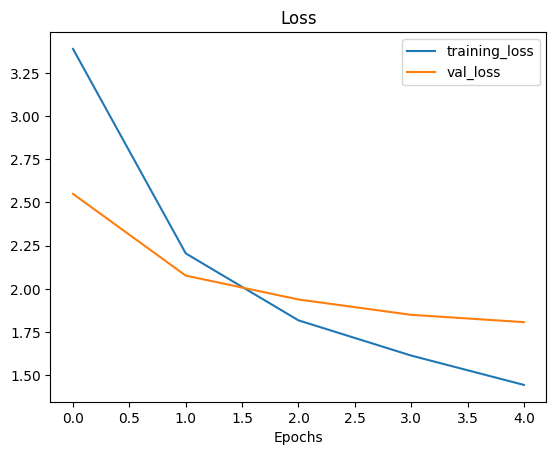

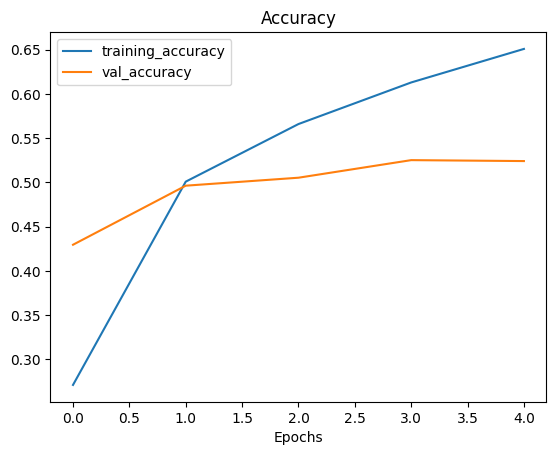

In [24]:
plot_loss_curves(history_all_classes_10_percent)

**Question:** These two curves should be very similar to each other. If not it may suggest that our model is overfitting (performing too well on traing data and not on unseen data).

## Fine-tuning

In [25]:
# Unfreeze all of te layers in the base model
base_model.trainable = True

# Refreeze every layer except
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [26]:
# Recompile model with lower learning (it's typically best proctice to lower lr in fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

In [27]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
glabal_pool_layer True
output_layer True


In [28]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_8 False
2 normalization_4 False
3 rescaling_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [29]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 955s 4s/step - loss: 1.4962 - accuracy: 0.6017 - val_loss: 1.8294 - val_accuracy: 0.5244
Epoch 6/10
237/237 [==============================] - 923s 4s/step - loss: 1.0756 - accuracy: 0.7043 - val_loss: 1.9157 - val_accuracy: 0.5139
Epoch 7/10
237/237 [==============================] - 979s 4s/step - loss: 0.8268 - accuracy: 0.7725 - val_loss: 2.1659 - val_accuracy: 0.4782
Epoch 8/10
237/237 [==============================] - 940s 4s/step - loss: 0.6591 - accuracy: 0.8094 - val_loss: 1.9091 - val_accuracy: 0.5373
Epoch 9/10
237/237 [==============================] - 929s 4s/step - loss: 0.5208 - accuracy: 0.8475 - val_loss: 1.9664 - val_accuracy: 0.5286
Epoch 10/10
237/237 [==============================] - 888s 4s/step - loss: 0.4175 - accuracy: 0.8816 - val_loss: 2.2702 - val_accuracy: 0.4961


In [30]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tuning_results = model.evaluate(test_data)
all_classes_10_percent_fine_tuning_results

790/790 [==============================] - 1748s 2s/step - loss: 1.7857 - accuracy: 0.5796


[1.7857134342193604, 0.5796039700508118]

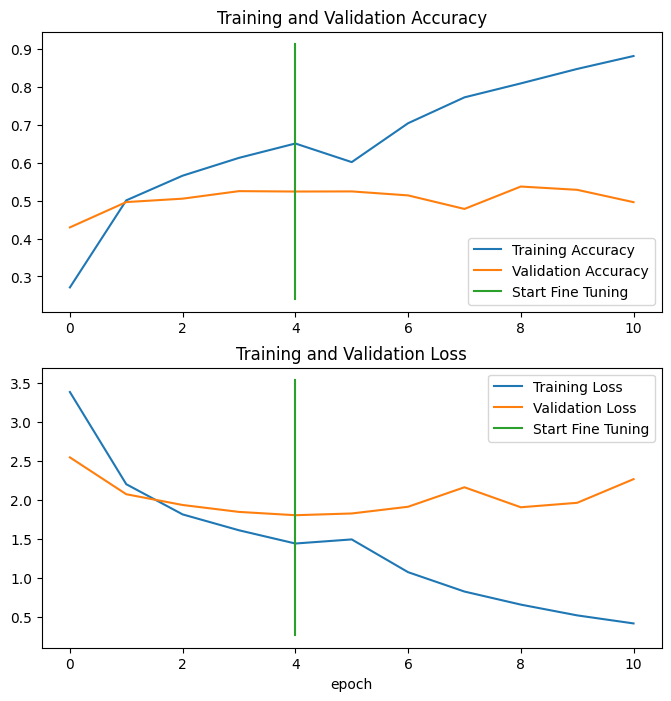

In [31]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and Loading our model

To use our model in an external application, we'll need to save it and export it somewhere

In [32]:
# Save our fine-tuning model
model.save("101_food_classes_10_percent_saved_big_dog_model")

In [33]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("101_food_classes_10_percent_saved_big_dog_model")

In [34]:
# Evaluate loaded model and compare
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 1817s 2s/step - loss: 1.7857 - accuracy: 0.5796


[1.7857134342193604, 0.5796039700508118]

In [35]:
all_classes_10_percent_fine_tuning_results

[1.7857134342193604, 0.5796039700508118]

## Evaluating the performance of the big dog model across all different classes

Let's make some predicitions, visualize them and then later find out which predictions were the "most" wrong.

In [36]:
import tensorflow as tf

# Download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-07-01 15:41:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.207, 209.85.200.207, 74.125.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   120MB/s    in 0.4s    

2024-07-01 15:41:13 (120 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [37]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [38]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [39]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 1758s 2s/step - loss: 1.8027 - accuracy: 0.6078


[1.8027209043502808, 0.6077623963356018]

## Making predictions with our trained model

In [40]:
# Make prediction with model
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 1875s 2s/step


In [41]:
len(test_data)

790

In [42]:
# Haw many predictions are there?
len(preds_probs)

25250

In [43]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [44]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[5.9541821e-02, 3.5742519e-06, 4.1377168e-02, ..., 1.4138705e-09,
        8.3531217e-05, 3.0897565e-03],
       [9.6401662e-01, 1.3753165e-09, 8.4780116e-04, ..., 5.4287248e-05,
        7.8361892e-12, 9.8465835e-10],
       [9.5925868e-01, 3.2533680e-05, 1.4867103e-03, ..., 7.1891884e-07,
        5.4396486e-07, 4.0276002e-05],
       ...,
       [4.7313419e-01, 1.2931264e-07, 1.4805606e-03, ..., 5.9750333e-04,
        6.6969194e-05, 2.3469374e-05],
       [4.4571679e-02, 4.7265243e-07, 1.2258522e-01, ..., 6.3498856e-06,
        7.5318644e-06, 3.6778755e-03],
       [7.2438991e-01, 1.9249704e-09, 5.2311065e-05, ..., 1.2291402e-03,
        1.5792813e-09, 9.6395706e-05]], dtype=float32)

In [48]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9541821e-02, 3.5742519e-06, 4.1377168e-02, 1.0660675e-09,
        8.1615665e-09, 8.6640304e-09, 8.0927339e-07, 8.5653056e-07,
        1.9858993e-05, 8.0978600e-07, 3.1728038e-09, 9.8674855e-07,
        2.8532455e-04, 7.8049772e-10, 7.4230431e-04, 3.8916522e-05,
        6.4741225e-06, 2.4977539e-06, 3.7891306e-05, 2.0678442e-07,
        1.5538582e-05, 8.1507471e-07, 2.6230612e-06, 2.0010795e-07,
        8.3827359e-07, 5.4216334e-06, 3.7391098e-06, 1.3150531e-08,
        2.7761399e-03, 2.8051751e-05, 6.8563449e-10, 2.5574851e-05,
        1.6688941e-04, 7.6408146e-10, 4.0453140e-04, 1.3150706e-08,
        1.7957528e-06, 1.4448282e-06, 2.3062961e-02, 8.2467005e-07,
        8.5366327e-07, 1.7138593e-06, 7.0525962e-06, 1.8402339e-08,
        2.8553589e-07, 7.9483289e-06, 2.0681885e-06, 1.8525219e-07,
        3.3619955e-08, 3.1522699e-04, 1.0411020e-05, 8.5449409e-07,
        8.4741849e-01, 1.0555525e-05, 4.4094534e-07, 3.7404636e-05,
        3.5306555e-05, 3.2489312e-05, 6.7314664e

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passes to the predict method.

In [49]:
# We get one prediction probability per class
print(f"Number pf prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number pf prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9541821e-02 3.5742519e-06 4.1377168e-02 1.0660675e-09 8.1615665e-09
 8.6640304e-09 8.0927339e-07 8.5653056e-07 1.9858993e-05 8.0978600e-07
 3.1728038e-09 9.8674855e-07 2.8532455e-04 7.8049772e-10 7.4230431e-04
 3.8916522e-05 6.4741225e-06 2.4977539e-06 3.7891306e-05 2.0678442e-07
 1.5538582e-05 8.1507471e-07 2.6230612e-06 2.0010795e-07 8.3827359e-07
 5.4216334e-06 3.7391098e-06 1.3150531e-08 2.7761399e-03 2.8051751e-05
 6.8563449e-10 2.5574851e-05 1.6688941e-04 7.6408146e-10 4.0453140e-04
 1.3150706e-08 1.7957528e-06 1.4448282e-06 2.3062961e-02 8.2467005e-07
 8.5366327e-07 1.7138593e-06 7.0525962e-06 1.8402339e-08 2.8553589e-07
 7.9483289e-06 2.0681885e-06 1.8525219e-07 3.3619955e-08 3.1522699e-04
 1.0411020e-05 8.5449409e-07 8.4741849e-01 1.0555525e-05 4.4094534e-07
 3.7404636e-05 3.5306555e-05 3.2489312e-05 6.7314664e-05 1.2852566e-08
 2.6219754e-10 1.0318246e-05 8.5743937e-05 1.

In [50]:
test_data.class_names[52]

'gyoza'

In [52]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [53]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions. Now we need to compare them to the original labels.

In [54]:
# To get our test labels, we'll need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

## Evaluate our model's predictions

One way to do this is to find the accuracy score.

In [55]:
results_downloaded_model

[1.8027209043502808, 0.6077623963356018]

In [57]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [58]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [59]:
from helper_functions import make_confusion_matrix

In [60]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [62]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)

## Time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall, and F1) called classification report.

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class by class evaluation of our model's predictions, but with so many classes, they're quite hard understand.

In [64]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [66]:
class_names[70]

'pad_thai'

Let's plot all of our classes F1-scores...

In [67]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [68]:
# Turn f1-scores into datafram for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [69]:
f1_scores

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


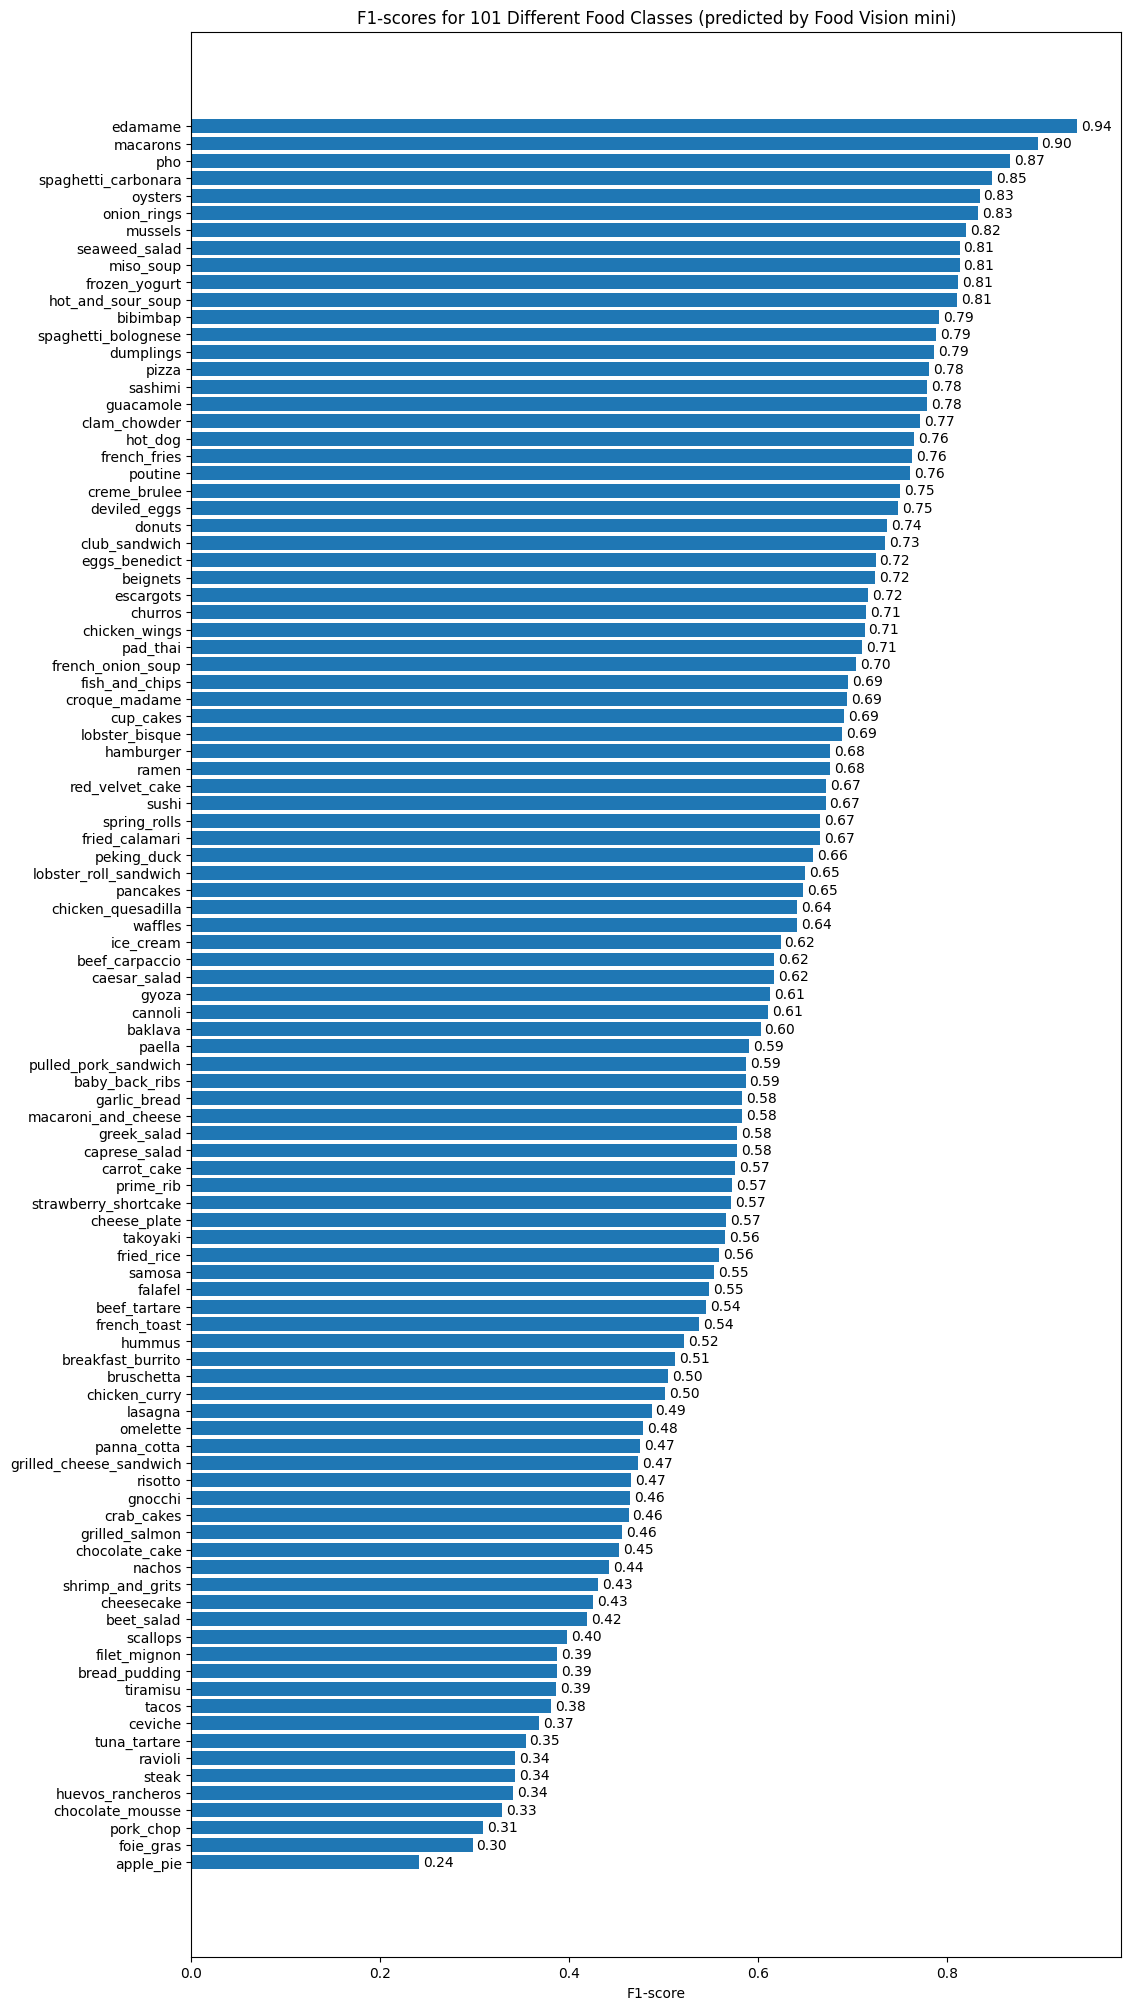

In [89]:
import matplotlib.pyplot as plt

def autolabel(rects):

    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        width = rect.get_width()
        height = rect.get_height()
        ax.annotate(f"{width:.2f}",
                    xy=(width, rect.get_y() + height / 2),
                    #xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(25, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='right', va='center')

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"]);
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis();
autolabel(scores)

## Visualize Predictions on custom images

How doe s the model go on food images, not in the test dataset?

To visualize our models's predictions on our own images, we'll need a function to oad and preprocess images, specifically it will need to:
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [90]:
# Createa a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, imag,shape, color_channels=3).

  Args:
    filename 9str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image
    return img/255.
  else:
    return img

Now we've got a function to load and prepare target images, let's now write some code tovisualize images, their target label and our model's predictions.

Specifically, we'll write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label


1/1 [==============================] - 0s 163ms/step


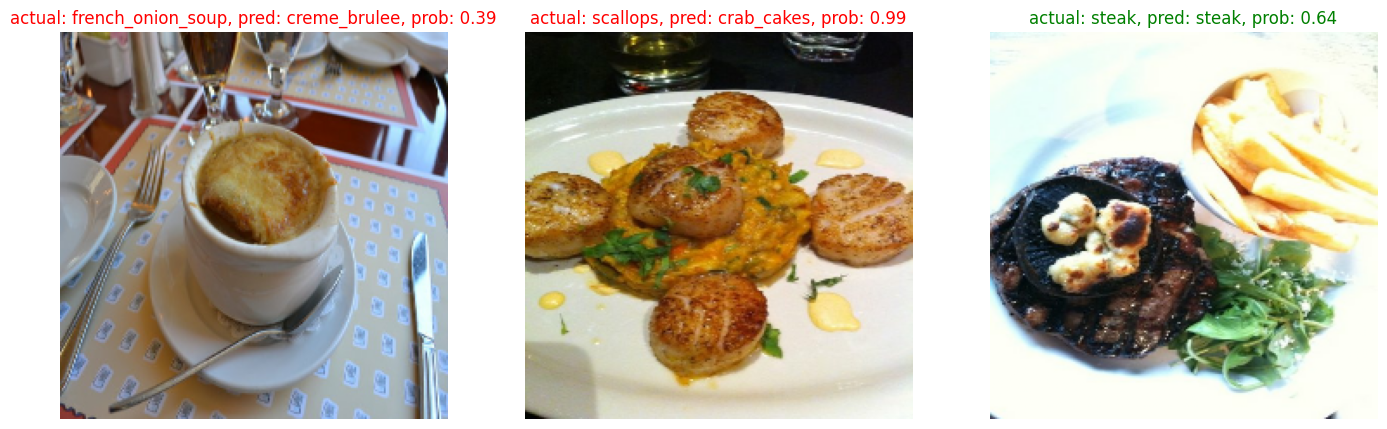

In [102]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find out where our model is mst wrong, let's write some code to find out the following:
1. Get all of the image file paaths in the test dataset using list_files() method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.